# Imports

In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Read test dataset and the number of elements in each class

In [27]:
data_test = np.load('Dataset5_raw_test.npz')
image_test, image_label_test = data_test['image'].astype(np.uint8), data_test['image_label'].astype(np.int8)
# x_test = np.concatenate([image_test[:838], image_test[839:1677], image_test[2043:2881], image_test[4083:4921], image_test[5564:6402]])
# y_test = np.concatenate([image_label_test[:838], image_label_test[839:1677], image_label_test[2043:2881], image_label_test[4083:4921], image_label_test[5564:6402]])
unique, counts = np.unique(image_label_test, return_counts=True)
counts

array([ 838, 1203, 2039, 1480,  980], dtype=int64)

# Read train and valid dataset and make it balanced

In [2]:
data_train = np.load('Dataset5_raw_train.npz')
image_train, image_label_train = data_train['image'].astype(np.uint8), data_train['image_label'].astype(np.int8)
x_train = np.concatenate([image_train[:2326], image_train[2512:4838], image_train[6119:8445], image_train[12234:14560], image_train[16672:18998]])
y_train = np.concatenate([image_label_train[:2326], image_label_train[2512:4838], image_label_train[6119:8445], image_label_train[12234:14560], image_label_train[16672:18998]])

In [3]:
data_val = np.load('Dataset5_raw_val.npz')
image_val, image_label_val = data_val['image'].astype(np.uint8), data_val['image_label'].astype(np.int8)
x_val = np.concatenate([image_val[:836], image_val[837:1673], image_val[2040:2876], image_val[4079:4915], image_val[5559:6395]])
y_val = np.concatenate([image_label_val[:836], image_label_val[837:1673], image_label_val[2040:2876], image_label_val[4079:4915], image_label_val[5559:6395]])

In [4]:
#Combining
image_total = np.concatenate([x_train, x_val])
label_total = np.concatenate([y_train, y_val])
del x_train, x_val, y_train, y_val, image_train, image_label_train, image_val, image_label_val

# Number of elements in each class (train+valid)

In [33]:
unique, counts = np.unique(label_total, return_counts=True)
counts

array([3162, 3162, 3162, 3162, 3162], dtype=int64)

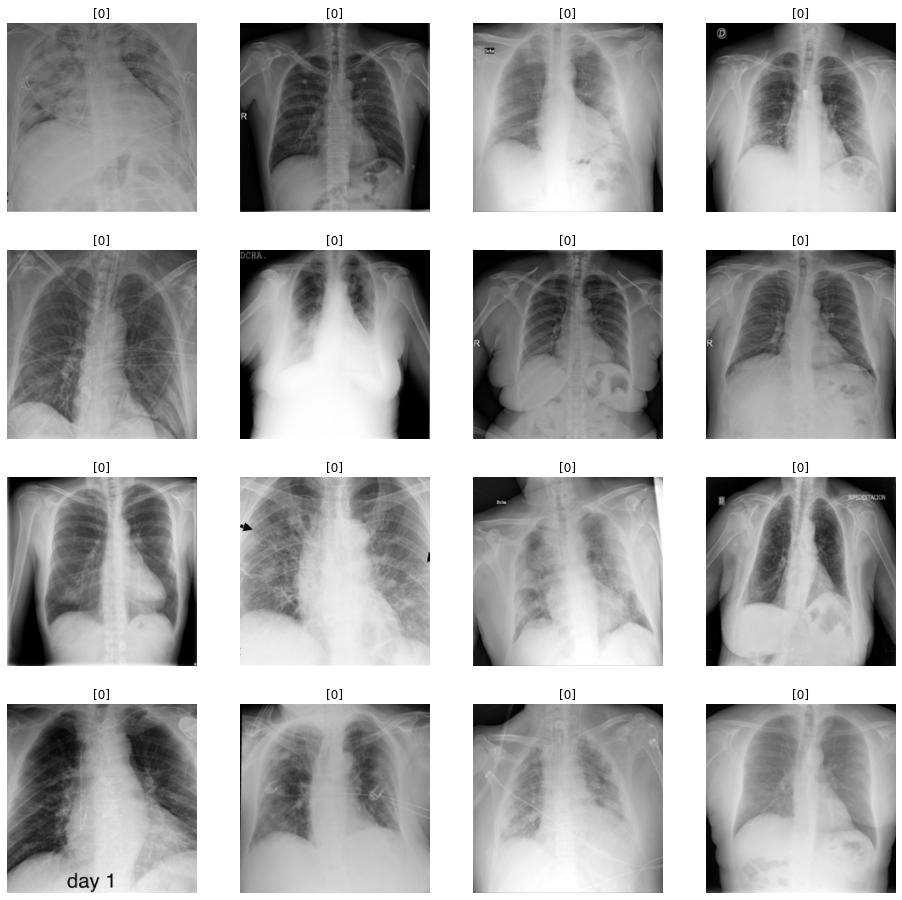

In [12]:
def plotImagesAndLabels():
    all_labels = np.unique(label_total)
    t_x, t_y = image_total, label_total
    fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
    for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
        #print([n_class for n_class, n_score in zip(all_labels, c_y) if n_score>0.5])
        c_ax.imshow(c_x[:,:,0], cmap = 'gray', vmin = 0, vmax = 255)
        c_ax.set_title(c_y)
        c_ax.axis('off')
plotImagesAndLabels()

 # Augmentation

In [32]:
import albumentations as A
COUNT_TEST = 1
COUNT = 1

for img, y in zip(image_test, image_label_test):
  # img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  y_str = str(y[0])
  resizeTransform = A.Compose([A.Resize(height=160, width=160, interpolation=1)], p=1)
  new_img = resizeTransform(image = img)['image']
  folder_to_save_img = "Images/Test"
  name_of_augmented_file = f"{COUNT_TEST}.jpg"
  cv2.imwrite(f"{folder_to_save_img}/{y_str}/{name_of_augmented_file}", new_img)
  COUNT_TEST+=1


for img, y in zip(image_total, label_total):
  y_str = str(y[0])
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) NO NEED TO CONVERT BGR TO RGB
  for i in range(2):
    resizeTransform = A.Compose([A.Resize(height=160, width=160, interpolation=1)], p=1)
    new_img = resizeTransform(image = img)['image']
    transform = A.Compose([
      A.ImageCompression(quality_lower = 80, quality_upper=100, p=0.7),
      A.GaussNoise(p=0.1),
      A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
      A.Flip(p = 0.4),
      A.OneOf([
        A.GaussianBlur(blur_limit=(1,3), sigma_limit=0, p=0.7),
        A.MedianBlur(blur_limit=(1,3), always_apply=False, p=0.3),
      ], p = 0.6),
      A.OneOf([
        A.Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.7),
        A.Rotate(limit=180, interpolation=1, border_mode=0, always_apply=False, p=0.3),
      ], p = 0.7),
      A.OneOf([
        A.Affine(scale = 1.4, translate_percent= None,shear = None, p=0.5),
        A.Affine(scale = None,translate_percent= 0.1, shear = None, p=0.25),
        A.Affine(scale = None,translate_percent= None,shear = (10,10), p=0.25), 
      ], p = 0.5),  
    ], 
    p = 1)

    aug = transform(image = new_img)["image"] 
    folder_to_save_img = "Images/Train"
    name_of_augmented_file = f"{COUNT}.jpg"
    if i == 0:
      image_to_save = new_img
    else:
      image_to_save = aug
    cv2.imwrite(f"{folder_to_save_img}/{y_str}/{name_of_augmented_file}", image_to_save)
    COUNT+=1

# Number of elements in each class after the augmentation 

In [38]:
sum = 0
for i in range(5):
    sum = sum + len(os.listdir(f'Images/Train/{i}'))
    print(f'{i}: ')
    print(len(os.listdir(f'Images/Train/{i}')))
print(f'total: {sum}')

0: 
6324
1: 
6324
2: 
6324
3: 
6324
4: 
6324
total: 31620
